In [1]:
%matplotlib inline

In [218]:
import time

import cvxpy
import numpy as np

from nengo.params import NumberParam
from nengo.solvers import Solver


class DalesSolver(Solver):
    """Solves for weights subject to Dale's principle."""
    
    # TODO: needs testing (e.g., transforms), support for slicing

    p_inh = NumberParam('p_inh', low=0, high=1)
    reg = NumberParam('reg', low=0)
    
    def __init__(self, p_inh=0.2, reg=1.):
        super(DalesSolver, self).__init__(weights=True)
        self.p_inh = p_inh
        self.reg = reg

    def __call__(self, A, Y, rng=None, E=None):
        pre_n_neurons = A.shape[1]
        post_n_neurons = E.shape[1]
        
        tstart = time.time()
        i = int(self.p_inh * pre_n_neurons)
        
        lmbda = self.reg*A.max()  # L2-regularization

        W = cvxpy.Variable(pre_n_neurons, post_n_neurons)
        objective = cvxpy.Minimize(
            cvxpy.sum_entries(cvxpy.square(A*W - Y.dot(E))) +
            cvxpy.sum_entries(lmbda*cvxpy.square(W)))
        constraints = [W[:i, :] <= 0,
                       W[i:, :] >= 0]
        prob = cvxpy.Problem(objective, constraints)
        value = prob.solve()

        # Do an extra clip for minor numerical reasons
        W = np.asarray(W.value)
        W[:i, :] = W[:i, :].clip(None, 0)
        W[i:, :] = W[i:, :].clip(0, None)

        return W, {
            'time': time.time() - tstart,
            'status': prob.status,
            'cost': value,
            'i': i,}

In [31]:
import nengo

with nengo.Network() as model:

    a = nengo.Ensemble(50, 2)
    b = nengo.Ensemble(25, 2)
    conn = nengo.Connection(a, b, solver=DalesSolver())
    
with nengo.Simulator(model) as sim:
    pass
    
W = sim.data[conn].weights

Building finished in 0:00:16.                                                   


In [32]:
from scipy.linalg import svd

U, S, V = svd(W)

from nengo.builder.ensemble import get_activities

x = np.linspace(-1, 1, 100)
A = get_activities(sim.data[a], a, x[:, None])

ValueError: shapes (100,1) and (2,50) not aligned: 1 (dim 1) != 2 (dim 0)

(100L, 20L) (10L, 10L) (20L, 20L) (10L, 20L)


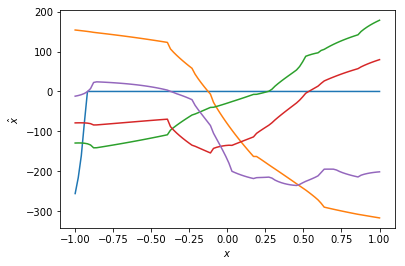

In [30]:
import matplotlib.pyplot as plt

print A.shape, U.shape, V.shape, W.shape

plt.figure()
plt.plot(x, A.dot(V[:5, :].T))
plt.xlabel(r"$x$")
plt.ylabel(r"$\hat{x}$")
plt.show()

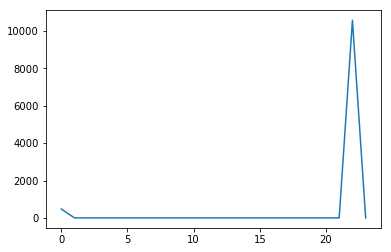

In [33]:
plt.plot(S[:-1] / S[1:])
plt.show()

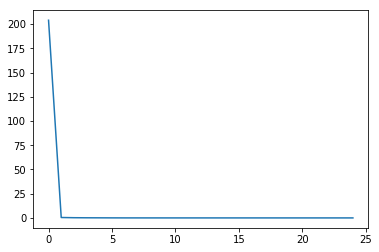

In [34]:
plt.plot(S)
plt.show()

In [245]:
import nengo

tau = 0.1
tau_probe = 0.005
dt = 0.001

with nengo.Network(seed=0) as model:
    stim = nengo.Node(output=lambda t: 2*np.pi*5*np.cos(2*np.pi*5*t))
    
    x = nengo.Ensemble(250, 1)

    # Discrete Principle 3 (Voelker & Eliasmith, 2017; eq 21)
    nengo.Connection(stim, x, transform=dt / (1 - np.exp(-dt/tau)), synapse=tau)
    conn = nengo.Connection(x, x, synapse=tau, solver=DalesSolver())
                            #solver=nengo.solvers.LstsqL2(weights=True))
    
    p_stim = nengo.Probe(stim, synapse=tau_probe)
    p_x = nengo.Probe(x, synapse=tau_probe)

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(1.0)
    
print("Solver Info:", sim.data[conn].solver_info)

Building finished in 0:23:27.                                                   
Simulating finished in 0:00:01.                                                 
('Solver Info:', {'status': 'optimal_inaccurate', 'i': 50, 'cost': 36322.59285690161, 'time': 1401.7860000133514})


0.395632
-0.00525572158053
0.00139706821818
-0.00610010793796
0.00165140951418


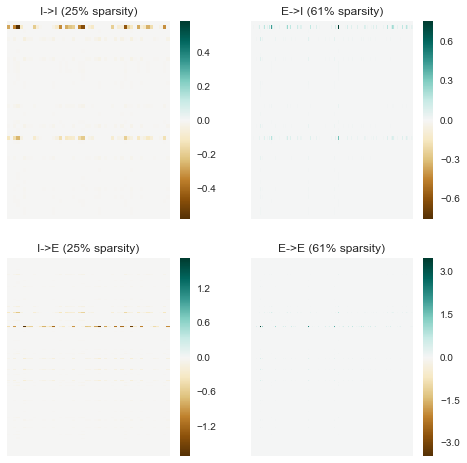

In [249]:
import seaborn as sns

W = sim.data[conn].weights
print(len(np.where(np.abs(sW.flatten()) < 1e-8)[0]) / float(W.size))

i = sim.data[conn].solver_info['i']

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for axis, sW, label in (
        (ax[0, 0], W[:i, :i], "I->I"),
        (ax[0, 1], W[:i, i:], "E->I"),
        (ax[1, 0], W[i:, :i], "I->E"),
        (ax[1, 1], W[i:, i:], "E->E"),):
    print np.mean(sW.flatten())
    sparsity = len(np.where(np.abs(sW.flatten()) < 1e-8)[0]) / float(sW.size)
    axis.set_title("%s (%d%% sparsity)" % (label, 100*sparsity))
    sns.heatmap(sW, ax=axis, center=0, cmap="BrBG",
                xticklabels=False, yticklabels=False)
plt.show()

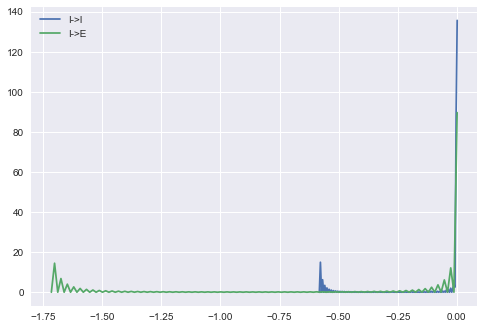

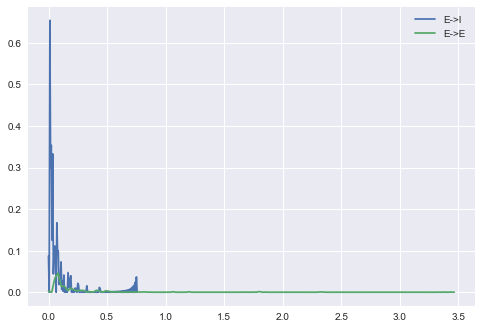

In [247]:
plt.figure()
sns.kdeplot(W[:i, :i].flatten(), label="I->I")
sns.kdeplot(W[i:, :i].flatten(), label="I->E")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(W[:i, i:].flatten(), label="E->I")
sns.kdeplot(W[i:, i:].flatten(), label="E->E")
plt.legend()
plt.show()

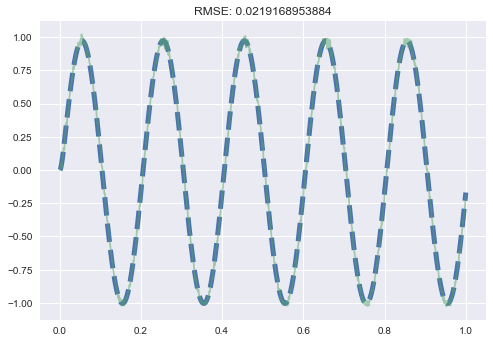

In [248]:
from nengo.utils.numpy import rmse

ideal = np.cumsum(sim.data[p_stim], axis=0)*dt

plt.figure()
plt.title("RMSE: %s" % (rmse(sim.data[p_x], ideal)))
plt.plot(sim.trange(), ideal, linestyle='--', lw=5)
plt.plot(sim.trange(), sim.data[p_x], alpha=0.5)
plt.show()